# Sanity Check model output test

In [1]:
import os

os.chdir("../..")

In [2]:
!pwd

/Users/wiktorlazarski/Desktop/my_project/head-segmentation


In [3]:
import head_segmentation.model as mdl
import head_segmentation.image_processing as ip

import scripts.training.data_loading as dl

import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (16, 12)
plt.rcParams["image.cmap"] = "gray"
plt.rcParams['savefig.facecolor'] = "white"

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
SANITY_CHECK_DSET_PATH = os.path.join(".", "data", "sanity_check_dataset", "train")
MODEL_PATH = os.path.join(".", "head_segmentation", "model", "last.ckpt")

In [5]:
dset = dl.CelebAHeadSegmentationDataset(dataset_root=SANITY_CHECK_DSET_PATH)
preprocessing_pipeline = ip.PreprocessingPipeline(nn_image_input_resolution=512)

model = mdl.HeadSegmentationModel.load_from_checkpoint(ckpt_path=MODEL_PATH)
model.eval()

print("Model loaded")

Model loaded


In [6]:
img, true_segmap = dset[1]

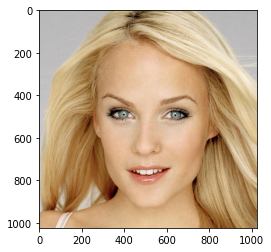

In [7]:
plt.imshow(img)

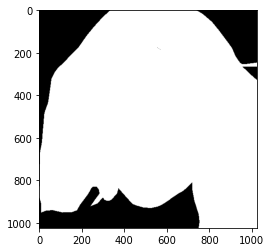

In [8]:
plt.imshow(true_segmap)

In [9]:
preprocessed_image = preprocessing_pipeline.preprocess_image(img)

In [10]:
preprocessed_image = preprocessed_image.unsqueeze(0)

In [11]:
preprocessed_image.shape

torch.Size([1, 3, 512, 512])

In [12]:
mdl_out = model(preprocessed_image)

In [13]:
mdl_out.shape

torch.Size([1, 2, 512, 512])

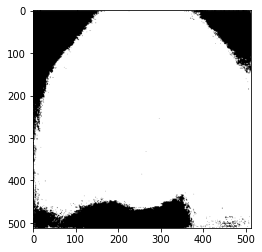

In [14]:
plt.imshow(mdl_out.argmax(dim=1).squeeze().numpy())

In [15]:
def postprocess(out, original_img_shape):
    out = out.squeeze()
    out = out.argmax(dim=0)
    out = out.numpy().astype(np.uint8)
    postprocessed = cv2.resize(out, original_img_shape, interpolation=cv2.INTER_NEAREST)
    
    return postprocessed

In [16]:
h, w = img.shape[:2]

In [17]:
pred_segmap = postprocess(mdl_out, original_img_shape=(w, h))

In [18]:
pred_segmap[0,...]

array([1, 1, 1, ..., 1, 1, 1], dtype=uint8)

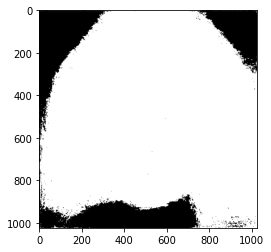

In [19]:
plt.imshow(pred_segmap)

In [20]:
segmented_region = np.zeros(img.shape, dtype=np.uint8)
segmented_region[pred_segmap == 1] = img[pred_segmap == 1]

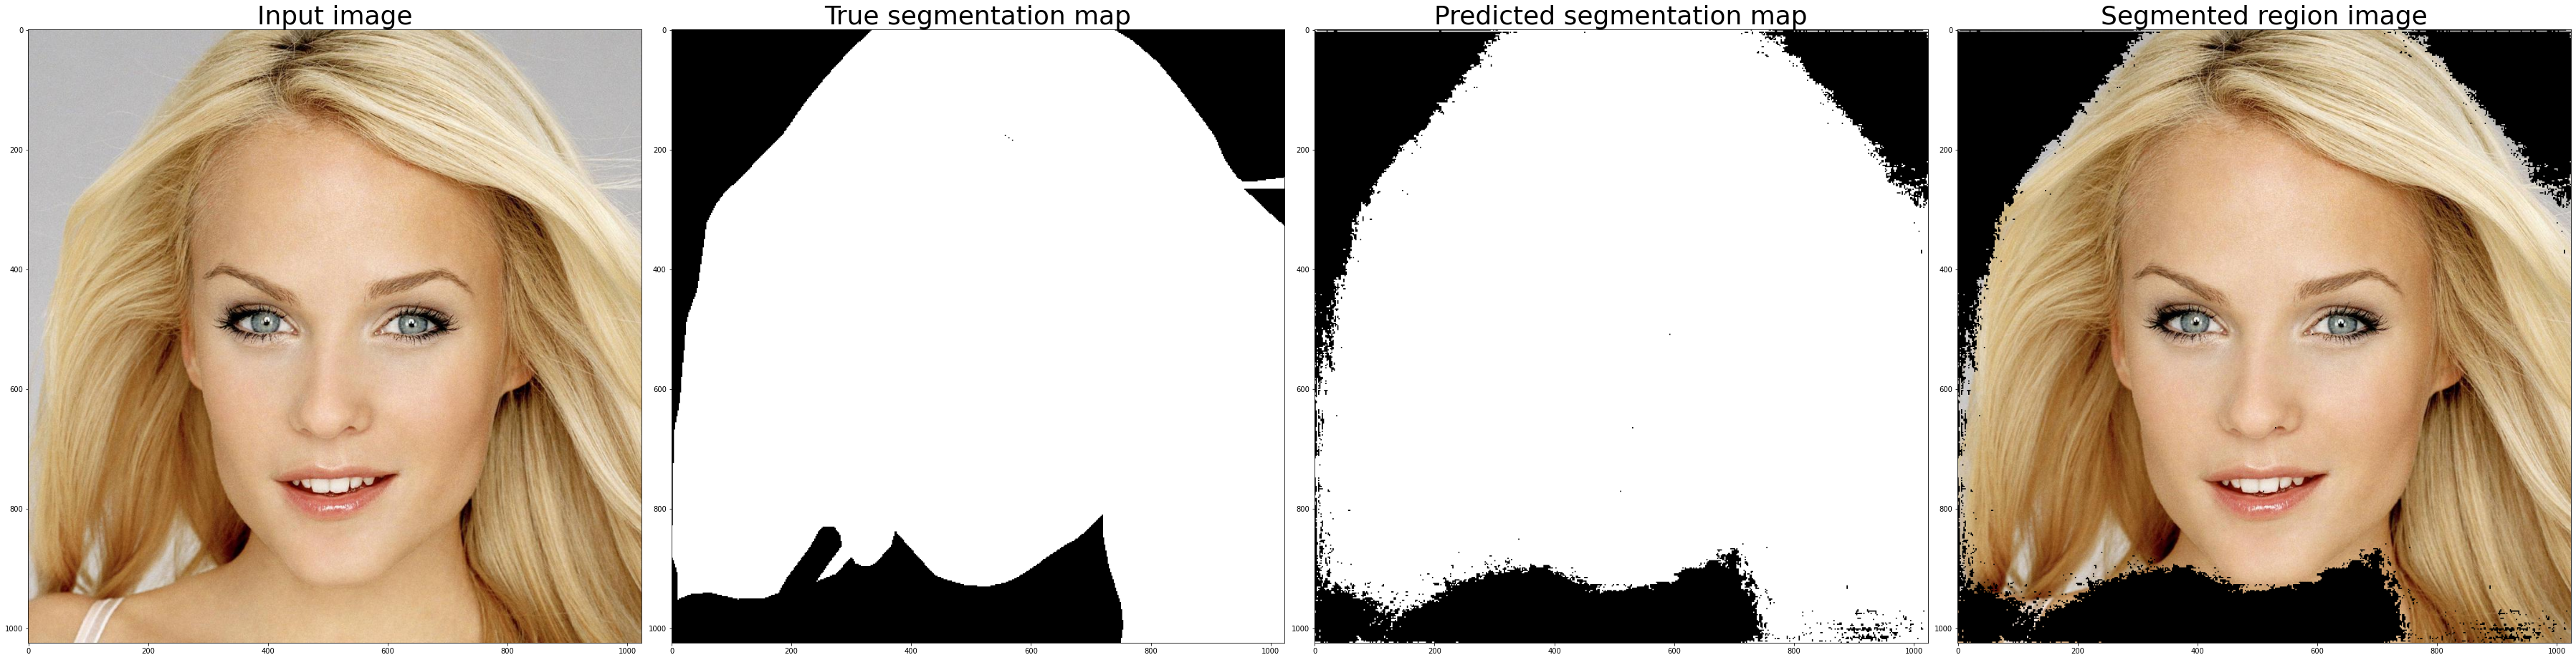

In [21]:
f, ax = plt.subplots(1, 4, figsize=(50, 20))
f.tight_layout()

fontsize = 36

ax[0].imshow(img)
ax[0].set_title("Input image", fontsize=fontsize)

ax[1].imshow(true_segmap)
ax[1].set_title("True segmentation map", fontsize=fontsize)

ax[2].imshow(pred_segmap)
ax[2].set_title("Predicted segmentation map", fontsize=fontsize)

ax[3].imshow(segmented_region)
ax[3].set_title("Segmented region image", fontsize=fontsize)

plt.savefig("out.png")
plt.show()